In [16]:
import matplotlib.pyplot as plt  
# iscrtavanje slika i plotova unutar samog browsera
%matplotlib inline 


import numpy as np
import cv2 # OpenCV biblioteka

In [17]:
cap = cv2.VideoCapture('videos/video-0.avi')

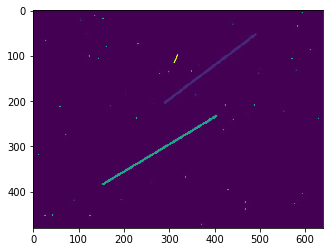

In [18]:
while(cap.isOpened()):
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    plt.imshow(gray)
    break;